In [1]:
library(rbmn)
data(boco)

Loading required package: MASS


In [2]:
round(head(boco), 1)

,A,H,W,C,TF,LF,AF,TL,LL,AL,TB,LB,AB
1,83,181.7,92.6,117,17.1,8.9,3,31.2,18.5,6.6,0.6,1.1,0.5
2,68,168.8,74.7,93,8.3,5.4,2,28,16.2,7.5,0.7,1,0.5
3,28,182.3,112.2,112,17.7,11.3,3.1,36.7,24.5,10.1,0.8,1.1,0.5
4,41,171.1,82.6,96,10.6,6.5,1.8,29.2,19.6,7.8,0.8,1.1,0.5
5,85,169.4,71.1,102,10.9,4.7,1.9,26.2,14.5,5.8,0.6,1.1,0.4
6,29,176,88.4,96,11.2,7.5,2.7,31.4,19.8,8.3,0.7,1,0.4


In [3]:
boco$B <- boco$W / boco$H^2 * 10^4
dim(boco)

[1] 100  14

In [4]:
n <- nrow(boco)
vr <- colnames(boco) [5:13]
co <- c("A", "H", "W", "C", "B")

set.seed(1234)
str <- sort(sample(n, round(n/2)))

dtr <- boco[str,]
dva <- boco[-str,]

print(c(dim(dtr), dim(dva)))

[1] 50 14 50 14


## Saturated RB

In [5]:
satua <- lm(cbind(TF, LF, AF, TL, LL, AL, TB, LB, AB) ~
             A + H + W + C + B, data = dtr)
r.dof <- anova(satua)["Residuals", "Df"]
satup <- predict(satua, newdata=dva)
satabiais <- abs(dva[,vr] - satup)
satstdev <- outer(rep(1, nrow(dtr)),
                  sqrt(colSums(residuals(satua)^2) / r.dof), 
                  "*")
satsep <- sqrt(satabiais^2 + satstdev^2)
satgsco <- cbind(colMeans(satabiais), colMeans(satstdev), colMeans(satsep))
colnames(satgsco) <- c("|Biais|", "Ec-Type", "SEP")
round(satgsco, 2)

,|Biais|,Ec-Type,SEP
TF,1.34,1.67,2.29
LF,1.17,1.56,2.04
AF,0.41,0.42,0.63
TL,1.28,1.60,2.19
LL,0.98,1.30,1.73
AL,0.54,0.70,0.94
TB,0.09,0.10,0.14
LB,0.11,0.12,0.17
AB,0.05,0.05,0.07


In [6]:
satsupe <- colSums(satgsco)
round(satsupe, 2)

|Biais| Ec-Type     SEP 
   5.97    7.51   10.19

## RB with constraints

In [7]:
library(bnlearn)

In [8]:
print(co)
print(vr)

[1] "A" "H" "W" "C" "B"
[1] "TF" "LF" "AF" "TL" "LL" "AL" "TB" "LB" "AB"


In [9]:
dag1 <- hc(dtr)

beg <- function(dag, l=80) paste(substr(modelstring(dag), 1, l), "...", sep="")

beg(dag1)

[1] "[A][TB][LB|TB][AB|TB:LB][H|AB][W|AB][B|H:W][C|A:H:AB:B][TF|C][AF|TF:B][LF|A:AF][..."

In [10]:
wl1 <- cbind(from=rep(co, each=9), to=rep(vr,5))
dag2 <- hc(dtr, whitelist=wl1)
print(beg(dag2))

[1] "[A][H][W|H][B|H:W][C|A:H:B][LB|A:H:W:C:B][AB|A:H:W:C:LB:B][AF|A:H:W:C:AB:B][TB|A..."


In [11]:
bl1 <- wl1[, 2:1]
dag3 <- hc(dtr, blacklist=bl1)
print(beg(dag3))
all.equal(dag2, dag3)

[1] "[A][H][W|H][B|H:W][C|A:H:B][TF|C][AF|TF:B][LF|A:AF][TL|A:W:TF:LF][AL|A:TL][TB|C:..."


[1] "Different number of directed/undirected arcs"

In [12]:
iwl <- 1:15
wl2 <- wl1[iwl,]
bl2 <- bl1[-iwl,]
dag4 <- hc(dtr, whitelist=wl2, blacklist=bl2)
print(beg(dag4))
dag4

[1] "[A][H][W|H][B|H:W][C|A:H:B][TF|A:H:C][TL|A:H:W:TF][AL|A:H:TL][LB|A:TF:TL][AB|A:A..."



  Bayesian network learned via Score-based methods

  model:
   [A][H][W|H][B|H:W][C|A:H:B][TF|A:H:C][TL|A:H:W:TF][AL|A:H:TL][LB|A:TF:TL]
   [AB|A:AL:LB][AF|A:H:W:TL:AB][TB|A:AB][LL|A:H:W:TF:AF:TL:LB]
   [LF|A:H:W:TF:AF:TL:LL:AL:LB]
  nodes:                                 14 
  arcs:                                  45 
    undirected arcs:                     0 
    directed arcs:                       45 
  average markov blanket size:           8.71 
  average neighbourhood size:            6.43 
  average branching factor:              3.21 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (Gauss.) 
  penalization coefficient:              1.956012 
  tests used in the learning procedure:  593 
  optimized:                             TRUE 


## Look for candidate RB's

In [13]:
bn2 <- bn.fit(dag2, data=dtr)

my.eval.bn <- function (bn, superf=T, rnd=2) {

    mn2 <- gema2mn(nbn2gema(bnfit2nbn(bn2)))
    biais <- stde <- dva[,vr]
    for (ind in 1:nrow(dva)) {
        mni <- condi4joint(mn2, par=vr, pour=co, unlist(dva[ind, co]))
        biais[ind,vr] <- dva[ind,vr] - mni$mu[vr]
        stde[ind, vr] <- sqrt(diag(mni$gamma)[vr])
    }
    
    sep <- sqrt(biais^2 + stde^2)
    
    gscores <- cbind(colMeans(abs(biais)), colMeans(stde), colMeans(sep))
    colnames(gscores) <- c("|Biais|", "Ec-Type", "SEP")
    
    if (superf)
        round(colSums(gscores), rnd)
    else
        round(gscores, rnd)
}

my.eval.bn(bn2,superf=F)

Warning message:
In if (class(bn.fit) != "bn.fit") {: la condition a une longueur > 1 et seul le premier élément est utilisé

,|Biais|,Ec-Type,SEP
TF,1.34,1.70,2.32
LF,1.17,1.57,2.06
AF,0.41,0.42,0.63
TL,1.28,1.83,2.37
LL,0.98,1.34,1.77
AL,0.54,0.79,1.00
TB,0.09,0.10,0.14
LB,0.11,0.12,0.17
AB,0.05,0.05,0.07


In [14]:
my.eval.bn(bn2)

Warning message:
In if (class(bn.fit) != "bn.fit") {: la condition a une longueur > 1 et seul le premier élément est utilisé

|Biais| Ec-Type     SEP 
   5.97    7.92   10.52

In [15]:
library(igraph)
load("bc.poco.rda")
cbind(posi,colo)[c(1:3, 10:11),]


Attaching package: ‘igraph’

The following objects are masked from ‘package:bnlearn’:

    compare, degree, path, subgraph

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



,x,y,colo
TF,95,25,white
LF,90,10,white
AF,85,50,white
A,70,65,lightgrey
H,30,65,lightgrey


Loading required namespace: graph


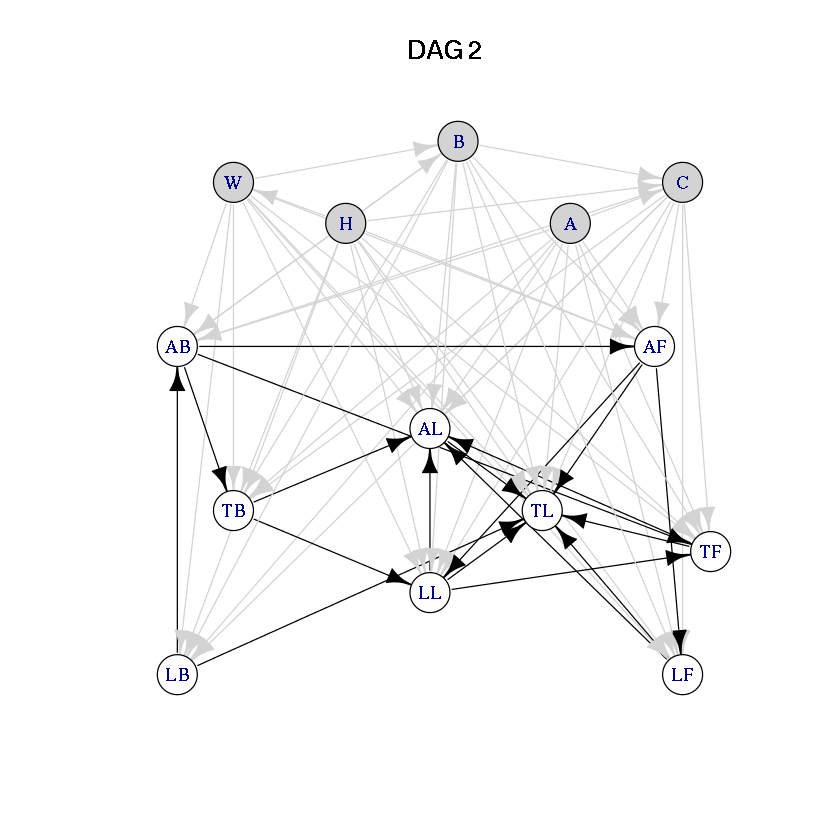

In [16]:
idag2 <- igraph.from.graphNEL(as.graphNEL(dag2))
nad <- V(idag2)$label <- V(idag2)$name
edcol <- rep("lightgrey", nrow(arcs(dag2)))
aa <- which((arcs(dag2)[, 1] %in% vr) &
            (arcs(dag2)[, 2] %in% vr))
va <- as.numeric(E(idag2, P=t(arcs(dag2)[aa,])))
edcol[va] <- "black"
plot(idag2, 
     layout        = posi[nad,], 
     main          = "DAG 2",
     edge.color    = edcol,
     vertex.color  = colo[nad])